In [27]:
from pynq_dpu import DpuOverlay
overlay = DpuOverlay("dpu.bit")

In [28]:
overlay.load_model("VGG11_CIFAR10_KV260.xmodel")

In [29]:
from time import time
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
%matplotlib inline
import xir

In [30]:
!pwd

/home/root/jupyter_notebooks/case_2024/vitis-ai


In [31]:
# graph= xir.Graph.deserialize("nuevo.xmodel")
# print(graph)

from dataset_loading import cifar
trainx, trainy, testx, testy, valx, valy = cifar.load_cifar_data("//home/root/jupyter_notebooks/case_2024/dataset", download=True, one_hot=False)

Tar File found in dest_dir. Not Downloading again
Extracting Python CIFAR10 data.
Files extracted


In [32]:
# images_path= "./images"
# files= os.listdir(images_path)

In [33]:
def preprocess_fn(image):
    mean= [0.485, 0.456, 0.406]
    std= [0.229, 0.224, 0.225]
#     image = cv2.imread(image_path)
#     image= cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    image = image.reshape(32,32,3)
    image = image * (1/255.0)
    image= (image-mean)/std

    return image

In [34]:
def desnorm(image):
    mean= [0.485, 0.456, 0.406]
    std= [0.229, 0.224, 0.225]
    image= image*std+mean
    return image

In [35]:
# labels= []
# for file in files:
#     labels.append(file.split("_")[0])

In [36]:
# index= 0
# image_path= os.path.join(images_path, files[index])
# image = cv2.imread(image_path)

# mean= [0.485, 0.456, 0.406]
# std= [0.229, 0.224, 0.225]
# image= cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# #image = image.reshape(32,32,3)
# image = image * (1/255.0)
# image= (image-mean)/std
# image.max(), image.min()
# #plt.imshow(image)
# #print(labels[index])

In [37]:
# index= 0
# image_path= os.path.join(images_path, files[index])
# #print(image_path)
# img_pre= preprocess_fn(image_path, 64)
# img_pre.shape

In [38]:
test_data= np.empty((len(testx),32,32,3))
#test_data.shape
i=0
for i in range(len(testx)):
    
#     image_path= os.path.join(images_path, file)
    img_pre= preprocess_fn(testx[i])
    test_data[i,...]= img_pre
    i+=1



In [39]:
test_data[0].shape

(32, 32, 3)

In [40]:
testx.min(), testx.max()

(0, 255)

In [41]:
dpu = overlay.runner

inputTensors = dpu.get_input_tensors()
outputTensors = dpu.get_output_tensors()

shapeIn = tuple(inputTensors[0].dims)
shapeOut = tuple(outputTensors[0].dims)
outputSize = int(outputTensors[0].get_data_size() / shapeIn[0])

softmax = np.empty(outputSize)

In [42]:
shapeIn, shapeOut

((1, 32, 32, 3), (1, 10))

In [43]:
output_data = [np.empty(shapeOut, dtype=np.float32, order="C")]
input_data = [np.empty(shapeIn, dtype=np.float32, order="C")]
image = input_data[0]

In [44]:
input_data[0].shape

(1, 32, 32, 3)

In [45]:
def calculate_softmax(data):
    result = np.exp(data)
    return result

In [46]:
test_data.shape

(10000, 32, 32, 3)

In [47]:
image[0,...] = test_data[0]

image.shape

(1, 32, 32, 3)

In [48]:
classes = ['plane', 'car' , 'bird',
    'cat', 'deer', 'dog',
    'frog', 'horse', 'ship', 'truck']

clases_np= np.array(classes)

In [49]:
# test_data[1,:,:,:].shape

# desnorm(test_data[1,:,:,:])

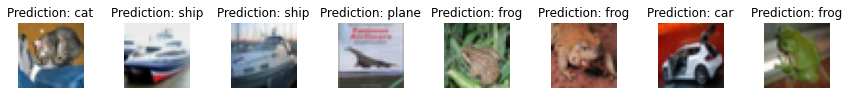

In [50]:
num_pics  = 8
fix, ax = plt.subplots(1, num_pics, figsize=(12,12))
plt.tight_layout()
for i in range(num_pics):
    
    image[0,...] = test_data[i]
    job_id = dpu.execute_async(input_data, output_data)
    dpu.wait(job_id)
    temp = [j.reshape(1, outputSize) for j in output_data]
    softmax = calculate_softmax(temp[0][0])
    prediction = softmax.argmax()

    ax[i].set_title('Prediction: ' + classes[prediction])
    ax[i].axis('off')
    ax[i].imshow(desnorm(test_data[i,:,:,:]))

In [52]:
total = test_data.shape[0]
# test_label=np.array(labels)
predictions = np.empty_like(testy)
print("Classifying {} digit pictures ...".format(total))
correct=0
start = time()
for i in range(total):
    image[0,...] = test_data[i]
    job_id = dpu.execute_async(input_data, output_data)
    dpu.wait(job_id)
    temp = [j.reshape(1, outputSize) for j in output_data]
    softmax = calculate_softmax(temp[0][0])
    predictions[i] = softmax.argmax()
    if predictions[i]==testy[i]:
        correct+=1
stop = time()
#correct = np.sum(clases_np[predictions]==test_label)
execution_time = stop-start
print("Overall accuracy: {}".format(correct/total))
print("  Execution time: {:.4f}s".format(execution_time))
print("      Throughput: {:.4f}FPS".format(total/execution_time))

Classifying 10000 digit pictures ...
Overall accuracy: 0.8892
  Execution time: 21.2264s
      Throughput: 471.1120FPS


In [26]:
def latency_measurement():
    image[0,...] = test_data[0]
    job_id = dpu.execute_async(input_data, output_data)
    dpu.wait(job_id)
    temp = [j.reshape(1, outputSize) for j in output_data]
    softmax = calculate_softmax(temp[0][0])
    predictions  = softmax.argmax()

In [27]:
one_image_validation_time = %timeit -n 1 -o latency_measurement()

2.4 ms ± 545 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [26]:
del overlay
del dpu